## Week 9 - 12 Report

### Key Tasks:

As compared to previous weeks, the tasks associated in this section of research is mainly to construct the proper model for CAD command prediction with reinforcement learning, and actually execute the training process.

- Construct novel model modified from original reconstruction task as proposed by Autodesk Research for the Fusion360Gallery Dataset.
- Understanding and modify the training pipeline for the proposed model with reinforcement learning.


### Helper Functions

We construct the following helper functions to help us prepare the data, mainly to transform the geometry information to that of graph information that can be used for our MPN Network

In [1]:
from __future__ import division
from __future__ import print_function

import os
import json
import time
import argparse
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from model_gcn import GCN

### Helper Functions

We construct the following helper functions to help us prepare the data, mainly to transform the geometry information to that of graph information that can be used for our MPN Network

#### Batch Convert .obj BREP into BREP Graphs

To create a training dataset, we batch convert the exisiting filtered BREPS into graph representation that could fit into the tensors of a GCN layer. This step is finished in Fusion360 in the form of a Python script. We use the pre-rpocessed data for the ease of demonstration. More information as to how to use Regraph for batch processing could be found here: https://github.com/AutodeskAILab/Fusion360GalleryDataset/tree/master/tools/regraph.

#### Load Dataset

We load the dataset from the disk and perform training

In [2]:
def format_graph_data(data,bbox):
    surf_type_dict={'ConeSurfaceType':2,'CylinderSurfaceType':1,'EllipticalConeSurfaceType':6,
    'EllipticalCylinderSurfaceType':5,'NurbsSurfaceType':7,'PlaneSurfaceType':0,
    'SphereSurfaceType':3,'TorusSurfaceType':4}
    node_names=[x['id'] for x in data['nodes']]
    # surface type
    features_SurTyp=np.zeros((len(node_names),8))
    for i in range(len(data['nodes'])):
        features_SurTyp[i,surf_type_dict[data['nodes'][i]['surface_type']]]=1
    # points
    features_Poi=np.zeros((len(node_names),len(data['nodes'][0]['points'])))
    for i in range(len(data['nodes'])):
        features_Poi[i,:]=data['nodes'][i]['points']
    mp1,mp2=bbox['max_point'],bbox['min_point']
    span_x,span_y,span_z=mp1['x']-mp2['x'],mp1['y']-mp2['y'],mp1['z']-mp2['z']
    scale=np.max([span_x,span_y,span_z,1e-2])
    features_Poi=features_Poi/scale
    # normals
    features_Nor=np.zeros((len(node_names),len(data['nodes'][0]['normals'])))
    for i in range(len(data['nodes'])):
        features_Nor[i,:]=data['nodes'][i]['normals']
    # trimming_mask
    features_TriMas=np.zeros((len(node_names),len(data['nodes'][0]['trimming_mask'])))
    for i in range(len(data['nodes'])):
        features_TriMas[i,:]=data['nodes'][i]['trimming_mask']
    features=np.concatenate((features_SurTyp,features_Poi,features_Nor,features_TriMas),axis=1)
    features=torch.FloatTensor(features)
    # edges
    edges_from,edges_to=[],[]
    for link in data['links']:
        if (link['source'] not in node_names) or (link['target'] not in node_names):
            continue
        idx1=node_names.index(link['source'])
        idx2=node_names.index(link['target'])
        edges_from.append(idx1)
        edges_to.append(idx2)
    adj=build_adjacency_matrix(len(node_names),edges_from,edges_to)
    adj=normalize(adj+sp.eye(adj.shape[0]))
    adj=sparse_mx_to_torch_sparse_tensor(adj)
    return adj,features


In [3]:
def load_dataset(args):
    action_type_dict={'CutFeatureOperation':1,'IntersectFeatureOperation':2,'JoinFeatureOperation':0,
    'NewBodyFeatureOperation':3,'NewComponentFeatureOperation':4}
    graph_pairs_formatted=[]
    # Check if this is a full path to a valid directory
    if os.path.isdir(args.dataset):
        dataset_path=args.dataset
    else:
        dataset_path='../data/%s'%(args.dataset)
    print("Using dataset_path:", dataset_path)
    dir_list=os.listdir(dataset_path)
    seqs=[x[:-14] for x in dir_list if (x.endswith('_sequence.json'))]
    if args.augment is not None and os.path.isdir(args.augment):
        aug_dataset_path=args.augment
        print('Loading augmentation data from:', aug_dataset_path)
        aug_dir_list=os.listdir(aug_dataset_path)
        aug_seqs=[x[:-14] for x in aug_dir_list if (x.endswith('_sequence.json'))]
        seqs.extend(aug_seqs)
        dir_list.extend(aug_dir_list)  
    # Check if this is a full path to a valid file
    if os.path.isfile(args.split):
        split_file=args.split
    else:
        split_file='../data/%s.json'%(args.split)
    with open(split_file) as json_data:
        train_test_split=json.load(json_data)
    # find number of steps
    seqs_num_step={}
    for seq in seqs:
        ct=0
        while True:
            if '%s_%04d.json'%(seq,ct) not in dir_list:
                seqs_num_step[seq]=ct
                break
            ct+=1
    counter=[0,0,0]
    for k in tqdm(range(len(seqs))):
        seq=seqs[k]
        # If we are training with synthetic data, ignore real training data
        if args.only_augment and seq in train_test_split["train"]:
            continue
        alt_dataset_path=dataset_path
        seq_file='%s/%s_sequence.json'%(dataset_path,seq)
        if not os.path.isfile(seq_file):
            alt_dataset_path=aug_dataset_path
        with open('%s/%s_sequence.json'%(alt_dataset_path,seq)) as json_data:
            data_seq=json.load(json_data)
        bbox=data_seq['properties']['bounding_box']
        len_equal = len(data_seq['sequence'])==seqs_num_step[seq]
        if not len_equal:
            print(f'Skipping {seq} due to unequal lengths: {len(data_seq["sequence"])} in json, but {seqs_num_step[seq]} files found')
            continue
#         assert(len(data_seq['sequence'])==seqs_num_step[seq])
        with open('%s/%s'%(alt_dataset_path,data_seq['sequence'][-1]['graph'])) as json_data:
            data_tar=json.load(json_data)
        adj_tar,features_tar=format_graph_data(data_tar,bbox)
        node_names_tar=[x['id'] for x in data_tar['nodes']]
        for sid,step in enumerate(data_seq['sequence']):
            if sid==0:
                adj_cur,features_cur=torch.zeros((0)),torch.zeros((0))
            else:
                with open('%s/%s'%(alt_dataset_path,data_seq['sequence'][sid-1]['graph'])) as json_data:
                    data_cur=json.load(json_data)
                adj_cur,features_cur=format_graph_data(data_cur,bbox)
            label_start_now=[node_names_tar.index(step['start_face'])]
            label_end_now=[node_names_tar.index(step['end_face'])]
            label_action_now=[action_type_dict[step['operation']]]
            label_start_now=torch.LongTensor(label_start_now)
            label_end_now=torch.LongTensor(label_end_now)
            label_action_now=torch.LongTensor(label_action_now)
            graph_pairs_formatted.append([adj_tar,features_tar,adj_cur,features_cur,label_start_now,label_end_now,label_action_now,seq,sid])
            counter[0]+=1
            counter[1]+=len(node_names_tar)
            counter[2]+=adj_tar.shape[0]
    print('total graph pairs: %d, total nodes: %d - %d'%(counter[0],counter[1],counter[2]))
    return graph_pairs_formatted

#### Training Methods: Imitation Learning

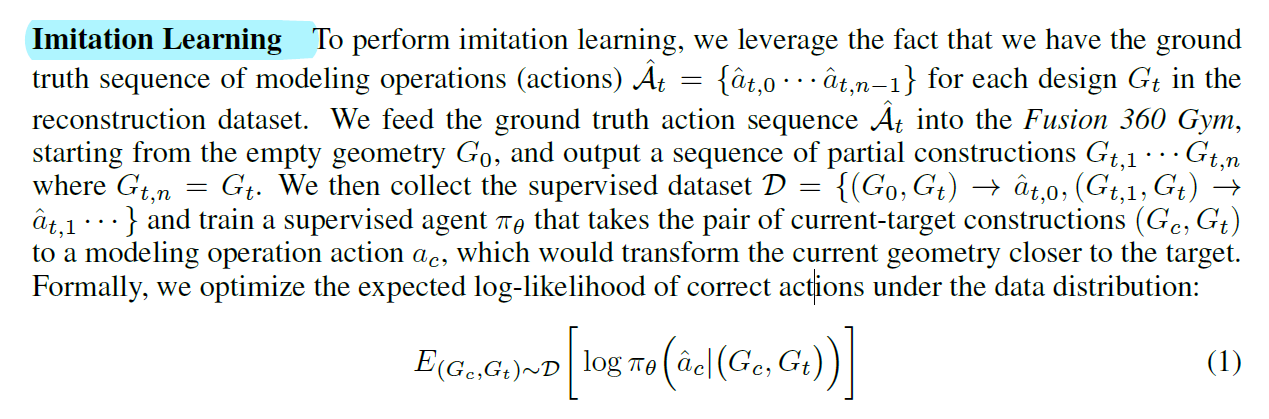


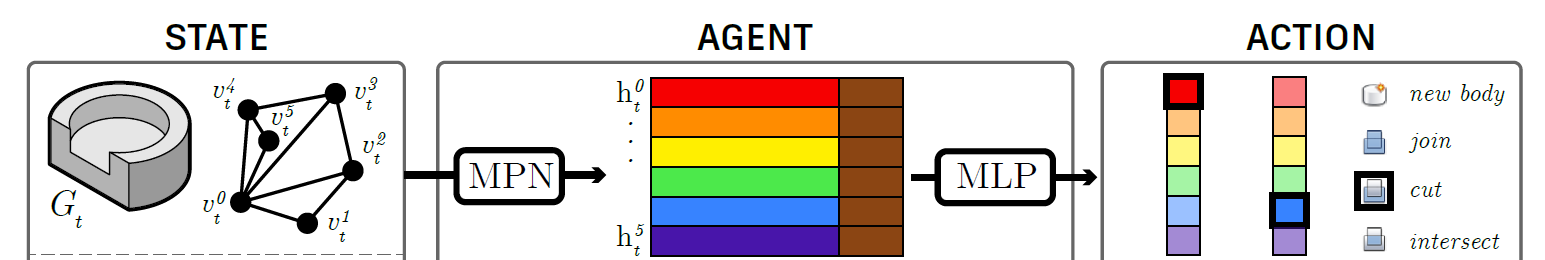

In [4]:
display.Image("illustrations/Agent.png")

#### Agent


##### State Space

##### Action Space


##### Reward Calculation

Calculate the reward

In [44]:
def build_adjacency_matrix(num_nodes,edges_from,edges_to):
    adj=sp.coo_matrix((np.ones(len(edges_from)),(edges_from,edges_to)),shape=(num_nodes,num_nodes),dtype=np.float32)
    adj=adj+adj.T.multiply(adj.T>adj)-adj.multiply(adj.T>adj)
    return adj

def normalize(mx):
    rowsum=np.array(mx.sum(1))
    r_inv=np.power(rowsum,-1).flatten()
    r_inv[np.isinf(r_inv)]=0.
    r_mat_inv=sp.diags(r_inv)
    mx=r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx=sparse_mx.tocoo().astype(np.float32)
    indices=torch.from_numpy(np.vstack((sparse_mx.row,sparse_mx.col)).astype(np.int64))
    values=torch.from_numpy(sparse_mx.data)
    shape=torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices,values,shape)

def accuracy(acc,output,labels):
    preds=output.max(1)[1].type_as(labels)
    correct=preds.eq(labels).double().sum().item()
    acc[0]+=correct
    acc[1]+=len(labels)
    return acc

def accuracy_overall(acc_all,output0,output1,output2,labels0,labels1,labels2):
    preds0=output0.max(1)[1].type_as(labels0)
    preds1=output1.max(1)[1].type_as(labels1)
    preds2=output2.max(1)[1].type_as(labels2)
    correct0=preds0.eq(labels0).item()
    correct1=preds1.eq(labels1).item()
    correct2=preds2.eq(labels2).item()
    correct=np.logical_and(np.logical_and(correct0,correct1),correct2)
    if correct:
        acc_all[0]+=1
    acc_all[1]+=1
    return acc_all,correct

### Core Module:

Neural Network


In [45]:
class NodePointer(nn.Module):
    def __init__(self,nfeat,nhid,dropout=0.0,Use_GCN=True):
        super(NodePointer,self).__init__()
        self.Use_GCN=Use_GCN
        self.nhid=nhid
        if Use_GCN:
            self.fc00=nn.Linear(nfeat,nhid)
            self.fc01=nn.Linear(nhid,nhid)
            self.fc10=nn.Linear(nfeat,nhid)
            self.fc11=nn.Linear(nhid,nhid)
            self.fc20=nn.Linear(nfeat*2,nhid)
            self.fc21=nn.Linear(nhid,nhid)
            self.gcn0=GCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.gcn1=GCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.gcn2=GCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.fc02=nn.Linear(nhid,nhid)
            self.fc03=nn.Linear(nhid,nhid)
            self.fc12=nn.Linear(nhid,nhid)
            self.fc13=nn.Linear(nhid,nhid)
            self.fc22=nn.Linear(nhid,nhid)
            self.fc23=nn.Linear(nhid,nhid)
        else:
            self.fc00=nn.Linear(nfeat,nhid)
            self.fc01=nn.Linear(nhid,nhid)
            self.fc10=nn.Linear(nfeat,nhid)
            self.fc11=nn.Linear(nhid,nhid)
            self.fc20=nn.Linear(nfeat*2,nhid)
            self.fc21=nn.Linear(nhid,nhid)
        self.fc_operation=nn.Linear(nhid,5)
        self.fc0=nn.Linear(nhid*2,nhid*2)
        self.fc1=nn.Linear(nhid*2,nhid*2)
        self.fc2=nn.Linear(nhid*2,nhid*2)
        self.fc3=nn.Linear(nhid*2,nhid*2)
        self.fc_start=nn.Linear(nhid*2,1)
        self.fc4=nn.Linear(nhid,nhid)
        self.fc5=nn.Linear(nhid,nhid)
        self.fc6=nn.Linear(nhid,nhid)
        self.fc7=nn.Linear(nhid,nhid)
        self.fc_end=nn.Linear(nhid,1)
        for m in self.modules():
            if isinstance(m,nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.00)

    def forward(self,gpf,use_gpu=True):
        x2=torch.cat((gpf[1],gpf[1][gpf[4],:].repeat(gpf[1].size()[0],1)),dim=1)
        if self.Use_GCN:
            x0=F.relu(self.fc01(F.relu(self.fc00(gpf[1]))))
            x0=self.gcn0(x0,gpf[0])
            x0=F.relu(self.fc03(F.relu(self.fc02(x0))))
            x2=F.relu(self.fc21(F.relu(self.fc20(x2))))
            x2=self.gcn2(x2,gpf[0])
            x2=F.relu(self.fc23(F.relu(self.fc22(x2))))
            if gpf[2].size()[0]==0:
                if use_gpu:
                    x1=torch.zeros((1,self.nhid)).cuda()
                else:
                    x1=torch.zeros((1,self.nhid))
            else:
                x1=F.relu(self.fc11(F.relu(self.fc10(gpf[3]))))
                x1=self.gcn1(x1,gpf[2])
                x1=F.relu(self.fc13(F.relu(self.fc12(x1))))
        else:
            x0=F.relu(self.fc01(F.relu(self.fc00(gpf[1]))))
            x2=F.relu(self.fc21(F.relu(self.fc20(x2))))
            if gpf[2].size()[0]==0:
                if use_gpu:
                    x1=torch.zeros((1,self.nhid)).cuda()
                else:
                    x1=torch.zeros((1,self.nhid))
            else:
                x1=F.relu(self.fc11(F.relu(self.fc10(gpf[3]))))
        x1=torch.sum(x1,dim=0,keepdim=True).repeat(x0.size()[0],1)
        # op represents operation to take
        op=self.fc_operation(x1[0:1,:])
        x=torch.cat((x0,x1),dim=1)
        x=F.relu(self.fc0(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        # x_start represents the start face
        x_start=self.fc_start(x)
        x2=F.relu(self.fc4(x2))
        x2=F.relu(self.fc5(x2))
        x2=F.relu(self.fc6(x2))
        x2=F.relu(self.fc7(x2))
        # x_end represents end face
        x_end=self.fc_end(x2)
        return x_start,x_end,op

#### Implementation of Training

In [51]:
class argParser(object):
    def __init__(self):
        self.dataset = "../data/regraph_04"
        self.augment = None#"../data/regraph_05"
        self.no_cuda = False
        self.seed = 42
        self.epochs = 100
        self.lr = 0.0001
        self.weight_decay = 5e-4
        self.hidden = 256
        self.dropout = 0.1
        self.no_gcn = False
        
        self.split = "train_test"
        self.use_gcn = True
        self.only_augment = False
        self.gcn = True        

args = argParser()
args.cuda=not args.no_cuda and torch.cuda.is_available()
args.gcn=not args.no_gcn

In [52]:
if args.cuda:
    torch.cuda.manual_seed(args.seed)
# data and model
graph_pairs_formatted=load_dataset(args)
model=NodePointer(nfeat=graph_pairs_formatted[0][1].size()[1],nhid=args.hidden,dropout=args.dropout,Use_GCN=args.gcn)
optimizer=optim.Adam(model.parameters(),lr=args.lr)
scheduler=ReduceLROnPlateau(optimizer,'min')
# cuda
if args.cuda:
    model.cuda()
    for i in range(len(graph_pairs_formatted)):
        for j in range(7):
            graph_pairs_formatted[i][j]=graph_pairs_formatted[i][j].cuda()
# train and test
train_test(graph_pairs_formatted,args)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 153.87it/s]

Using dataset_path: ../data/regraph_04
total graph pairs: 10, total nodes: 104 - 104


NameError: name 'train_test' is not defined

In [ ]:
        # test
        model.eval()
        loss,acc0,acc1,acc2,acc_all=0,[0,0],[0,0],[0,0],[0,0]
        shape_ids,not_perfect_shapes={},[]
        with torch.no_grad():
            for iter in tqdm(range(len(graph_pairs_formatted))):
                if graph_pairs_formatted[iter][7] not in train_test_split['test']:
                    continue
                if graph_pairs_formatted[iter][7] not in shape_ids:
                    shape_ids[graph_pairs_formatted[iter][7]]=graph_pairs_formatted[iter][8]
                else:
                    if graph_pairs_formatted[iter][8]>shape_ids[graph_pairs_formatted[iter][7]]:
                        shape_ids[graph_pairs_formatted[iter][7]]=graph_pairs_formatted[iter][8]
                output_start,output_end,output_op=model(graph_pairs_formatted[iter])
                output_start=output_start.view(1,-1)
                output_end=output_end.view(1,-1)
                loss0=F.cross_entropy(output_start,graph_pairs_formatted[iter][4],reduction='sum')
                loss1=F.cross_entropy(output_end,graph_pairs_formatted[iter][5],reduction='sum')
                loss2=F.cross_entropy(output_op,graph_pairs_formatted[iter][6],reduction='sum')
                loss_now=loss0+loss1+loss2
                acc0=accuracy(acc0,output_start,graph_pairs_formatted[iter][4])
                acc1=accuracy(acc1,output_end,graph_pairs_formatted[iter][5])
                acc2=accuracy(acc2,output_op,graph_pairs_formatted[iter][6])
                acc_all,correct=accuracy_overall(acc_all,output_start,output_end,output_op,graph_pairs_formatted[iter][4],graph_pairs_formatted[iter][5],graph_pairs_formatted[iter][6])
                if (not correct) and (graph_pairs_formatted[iter][7] not in not_perfect_shapes):
                    not_perfect_shapes.append(graph_pairs_formatted[iter][7])
                loss=loss+loss_now.item()
        acc_shape=[len(shape_ids)-len(not_perfect_shapes),len(shape_ids)]
        step_counter={}
        for seq in shape_ids:
            if seq not in not_perfect_shapes:
                if shape_ids[seq]+1 not in step_counter:
     a               step_counter[shape_ids[seq]+1]=0
                step_counter[shape_ids[seq]+1]+=1
        print('(Test)Epoch:{:04d}'.format(epoch+1),'loss: {:.4f}'.format(loss/acc0[1]),'start: {:.3f}'.format(acc0[0]/acc0[1]*100.0),'end: {:.3f}'.format(acc1[0]/acc1[1]*100.0),'op: {:.3f}'.format(acc2[0]/acc2[1]*100.0))
        print('Steps: ',int(acc_all[0]),'/',acc_all[1],'percent: {:.3f}'.format(acc_all[0]/acc_all[1]*100.0))
        print('Shapes: ',int(acc_shape[0]),'/',acc_shape[1],'percent: {:.3f}'.format(acc_shape[0]/acc_shape[1]*100.0),step_counter)
        log_results(results,exp_name,'Test',epoch,loss,acc0,acc1,acc2,acc_all)